# Common import and setup


In [1]:
import os, sys, time, pytest

import matplotlib.pyplot as plt
from matplotlib import patches, lines
import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import pdfminer

from IPython.display import display

# Make sure we use the local version of camelot if it is here
sys.path.insert(0, os.path.abspath(''))

import camelot
from camelot.core import Table, TableList, TextEdges
from camelot.__version__ import generate_version
from camelot.utils import get_text_objects, text_in_bbox
from camelot.parsers.stream import Stream
from camelot.parsers.hybrid import Hybrid
from camelot.handlers import PDFHandler
from camelot.plotting import draw_pdf
from tests.data import *

testdir = os.path.dirname(os.path.abspath('.'))
testdir = os.path.join(testdir, "camelot/tests/files")

# Set up plots to be large enough for visualization

# To check which library we're using
camelot.__file__


'/Users/francoishuet/Code/camelot/camelot/__init__.py'

In [2]:
kwargs = {}
data = None
# pdf_file = "vertical_header.pdf"  # test_hybrid_vertical_header
# pdf_file, kwargs = "background_lines_1.pdf", {} # {"process_background": True}  # test_lattice_process_background

# pdf_file, kwargs, data = "superscript.pdf", {"flag_size": True}, data_stream_flag_size # test_hybrid_flag_size
# pdf_file = "health.pdf"  # test_hybrid
# pdf_file = "clockwise_table_2.pdf"
# pdf_file = "tabula/12s0324.pdf"  # interesting because contains two separate tables
# pdf_file, kwargs = "tabula/us-007.pdf", {"table_regions": ["320,335,573,505"]} # test_hybrid_table_regions
# pdf_file, kwargs = "detect_vertical_false.pdf", {"strip_text": " ,\n"}  # data_stream_strip_text
# pdf_file, kwargs, data = "tabula/m27.pdf", {"columns": ["72,95,209,327,442,529,566,606,683"], "split_text": True, }, data_stream_split_text  # data_stream_split_text

pdf_file = "vertical_header.pdf"

# pdf_file = "twotables_2.pdf"
# pdf_file = "camelot-issue-132-multiple-tables.pdf"
# pdf_file, kwargs, data = "edge_tol.pdf", {"edge_tol": 500}, data_stream_edge_tol
# pdf_file, kwargs, data = "edge_tol.pdf", {}, data_stream_edge_tol

filename = os.path.join(testdir, pdf_file)

Found 1 tables (17x22) in 0.77s


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,,,,,,,,,,,...,Senator 36th,Rep106th,,Reg. of,,Road,,,Distri,Dist
1,,,,,,,,,,,...,Dist.,Dist.,,Deeds,,Commission,,District #1,ct #2,#3\nDist #4
2,,,,,,Governor,,,U.S. Senator,,...,,,,,,,,,,
3,,Number of Registered voters,Poll Book Totals,Brian Calley,Patrick Colbeck,Jim Hines,Bill Schuette,John James,Sandy Pensler,,...,Jim Stamas,Sue Allor,Melissa A. Cordes,,Al Scully,,Daniel G. Gauthier,Craig M. Clemens,Craig Johnston,Carolyn Brummund\nAdam Brege\nDavid Bielusiak
4,Alcona,963,439,55,26,47,164,173,111,,...,272,275,269,,271,,224,76,,
5,Caledonia,923,393,40,23,45,158,150,103,,...,247,254,255,,244,,139,143,,
6,Curtis,1026,349,30,30,25,102,95,84,,...,164,162,161,,157,,,,,
7,Greenbush,1212,423,56,26,40,126,104,131,,...,213,214,215,,208,,,,,208
8,Gustin,611,180,22,35,17,55,73,45,,...,104,111,111,,109,,,,,81\n42
9,Harrisville,1142,430,45,90,29,101,155,94,,...,226,232,244,,226,,,,232,


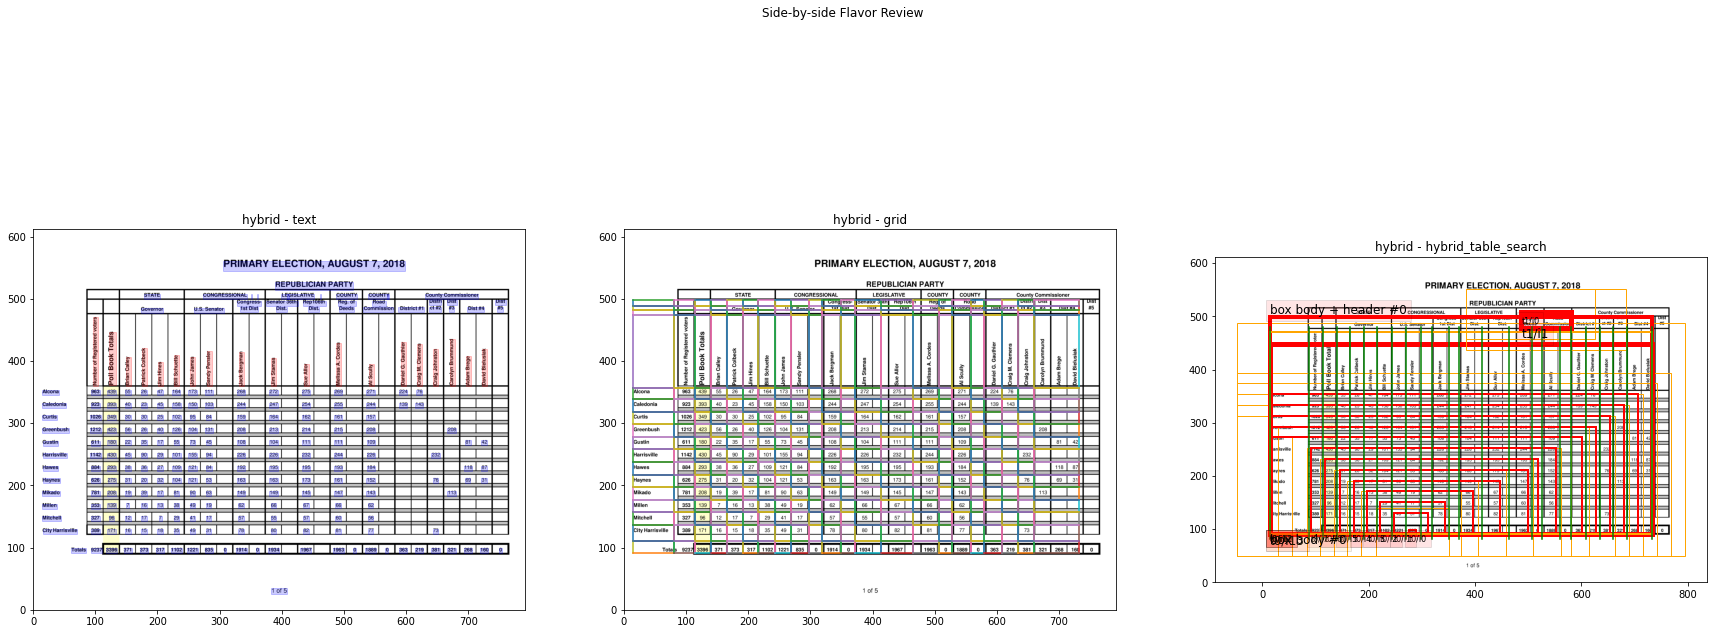

In [3]:

PLOT_TYPES = ["text", "grid", "hybrid_table_search"]
PLOT_HEIGHT = 12
plt.rcParams["figure.figsize"] = [PLOT_HEIGHT * 2.5, PLOT_HEIGHT]
fig, axes = plt.subplots(1, len(PLOT_TYPES))
fig.suptitle('Side-by-side Flavor Review')
tables_list = []
flavor = "hybrid"
timer_before_parse = time.perf_counter()
tables = camelot.read_pdf(filename, flavor=flavor, debug=True, **kwargs)
tables_list.append(tables)
timer_after_parse = time.perf_counter()

if len(tables):
    tables_dims = ", ".join(
        map(
            lambda table: "{rows}x{cols}".format(
                rows=table.shape[0],
                cols=table.shape[1],
            ), tables
        )
    )
    print("Found {table_num} tables ({tables_dims}) in {parse_time:.2f}s".format(
        table_num=len(tables),
        tables_dims=tables_dims,
        parse_time=timer_after_parse - timer_before_parse,
    ))
    for table in tables:
        display(table.df)
        for plot_idx, plot_id in enumerate(PLOT_TYPES):
            ax = axes[plot_idx]
            fig = camelot.plot(table, kind=plot_id, ax=ax)
            ax.set_title("{flavor} - {plot_id}".format(
                flavor=flavor,
                plot_id=plot_id,
            ))

timer_after_plot = time.perf_counter()
fig


In [4]:
tables = camelot.read_pdf(filename, flavor='stream')
fig = camelot.plot(tables[0], kind='text')


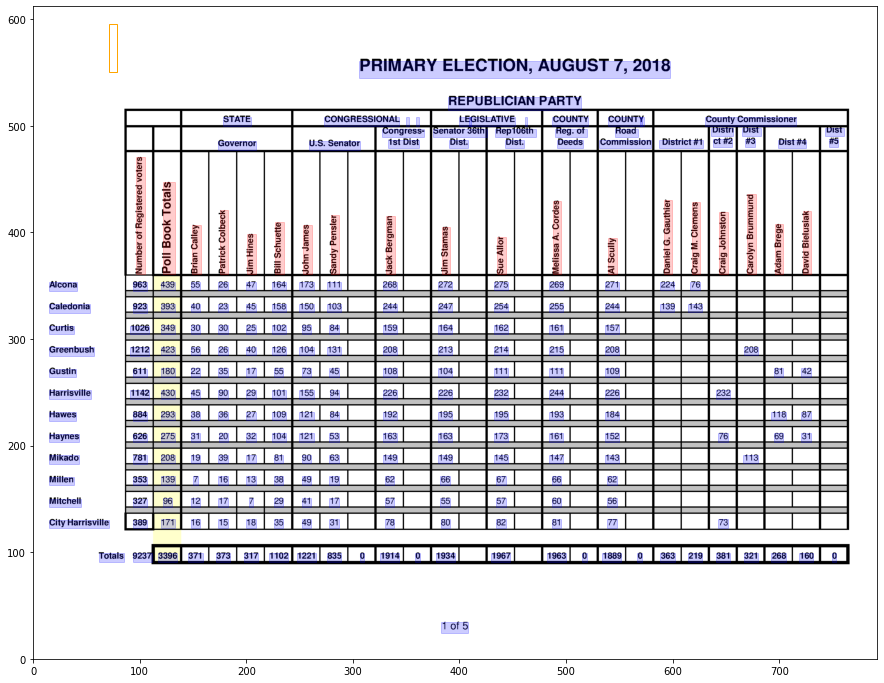

In [5]:
ax = fig.add_subplot(111, aspect="equal")

def add_rectangle(ax, bbox, color):
    ax.add_patch(
        patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
            fill=False, color=color
        )
    )

add_rectangle(ax, (71.039971584, 766.039693584, 78.46358609455301, 792.439683024), "blue") # most aligned
add_rectangle(ax, [71.039971584, 766.039693584, 528.2376647048496, 792.439683024], "green") # current bbox
add_rectangle(ax, (71.039971584, 550.759779696, 78.46358609455301, 595.879761648), "orange") # t considered
fig
